In [38]:
library(dplyr)
library(data.table)
library(parallel)
library(NMF)
library(CRF)
library(cowplot)
library(ggplot2)


In [3]:
## load the functions for running clean up
source('./decontam.R') # change directory to where you stored decontam.R


Two data files are needed for this tutorial, which can be downloaded at the following url:
https://nanostring.com/products/cosmx-spatial-molecular-imager/ffpe-dataset/nsclc-ffpe-dataset/ 
- "[Processed Giotto Object](https://nanostring.com/resources/smi-ffpe-dataset-giotto-object/)"
- "[Lung 5-1 Data files](https://nanostring.com/resources/smi-ffpe-dataset-lung5-rep1-data/)"


In [4]:
## load the molecule-level NSCLC spatial data
tx_dat <- read.csv(file='./Lung5_Rep1/Lung5_Rep1-Flat_files_and_images/Lung5_Rep1_tx_file.csv')


In [5]:
# load the giotto object to get cell type annotations
load('./giotto_dat/SMI_Giotto_Object.RData')


Important: to run the pipeline of KNN graph -> NMF -> CRF, we need to include columns
in the molecule-level dataframe called:
- 'cell' specifying the cell that the molecule belongs to
- 'x','y','z' specifying the coordinates of the transcript. Note, if no z coordinates exist for your data, you can set that column to a constant value.
- 'gene' specifying the gene that the molecule corresponds to
- 'mol_id' a character which is unique to a give molecule (can just be row index)

In [6]:
# Creating a new cell ID column to match the metadata in giotto object
tx_dat$cell <- paste0('c_1_',tx_dat$fov,'_',tx_dat$cell_ID)

In [7]:
# extract relevant metadata from giotto object
cell_meta <- gem@cell_metadata$rna
cell_locs <- gem@spatial_locs$raw
meta_total <- cbind.data.frame(cell_locs[,c(1:2)],cell_meta)

# subset to a single donor/replicate
cell_annot <- meta_total[meta_total$Run_Tissue_name=='Lung5_Rep1',]
colnames(cell_annot)[3] <- 'cell'
colnames(cell_annot)[34] <- 'celltype'

# subsetting data to same cells we have annotations for
df <- tx_dat[tx_dat$cell %in% cell_annot$cell,]

# append cell type annotations to molecule-level data
match_ndx <- match(df$cell,cell_annot$cell)
df$celltype <- cell_annot$celltype[match_ndx]


In [8]:
# Change x and y coordinate column names
colnames(df)[3:4] <- c('x','y')

# Change gene column name
colnames(df)[8] <- c('gene')

# adding a column for molecule ID
df$mol_id <- as.character(1:nrow(df))


In [9]:
# converting coordinate units from pixels to microns based on information from their publication
df$x <- (df$x * 180) / 1000
df$y <- (df$y * 180) / 1000

# assigning z-coordinates to an expected height in microns
df$z <- (df$z * 800) / 1000

We're going to focus our analysis on the fibroblasts for this demonstration.

In [11]:
# We'll the df to only fibroblasts
ct <- 'fibroblast'
df <- df[df$celltype==ct,]

# subset to only fibroblasts inside the tumor interior niche to help pull out the contamination signal
match_ndx <- match(df$cell,cell_annot$cell)
df$niche <- cell_annot$niche[match_ndx]
df <- df[df$niche=='tumor interior',]

# removing unneeded columns from the df
df <- df[,c('cell','gene','mol_id','x','y','z')]

print(head(df))

           cell     gene mol_id        x        y   z
826495 c_1_2_76     MMP1 493361 2399.334 28573.55 7.2
826496 c_1_2_76 HLA-DQB1 493362 2397.822 28572.18 2.4
826497 c_1_2_76   COL1A2 493363 2398.117 28570.65 2.4
826498 c_1_2_76     C1QB 493364 2397.170 28573.14 2.4
826499 c_1_2_76     RGS2 493365 2402.366 28561.64 2.4
826500 c_1_2_76     CD68 493366 2397.301 28573.15 2.4


Now, we'll compute the neighborhood composition vectors (knn for each molecule) and run NMF on this

In [26]:
# compute the molecule NCV matrix
N <- get_knn_counts(df, h = 20, include_i = TRUE, ncores = 20)

genes = unique(df$gene) %>% sort

X = N %>% 
  select(all_of(genes), id) %>%
  tibble::column_to_rownames('id') %>%
  as.matrix

print(dim(X))
print(X[1:5,1:5])

[1] 251971    980
         AATK ABL1 ABL2 ACE ACE2
11471268    0    0    0   0    0
11471269    0    0    0   0    0
11471270    0    0    0   0    0
11471271    0    0    0   0    0
11471272    0    0    0   0    0


In [28]:
# downsampling X for for faster runntime for the demonstration
rows_select <- sample(1:nrow(X),5000,replace = FALSE)
X <- X[rows_select,]
X = X[rowSums(X) > 0,colSums(X) > 0]

# computing the weights matrix to use in weighted NMF
Z = matrix(rep(1/colSums(X), nrow(X)), nrow = nrow(X), byrow = TRUE)

# k parameter is the number of factors to use in the NMF decomposition
k <- 5

res <- NMF::nmf(X, rank = k, method = 'ls-nmf', weight = Z, nrun = 30, .opt='vmp30', seed=0)

NMF algorithm: 'ls-nmf'

Multiple runs: 30

Mode: parallel (30/128 core(s))



Runs: |==================================================| 100%
System time:
     user    system   elapsed 
14310.640  5023.765  1356.615 


In [29]:
# compute fractional loadings
H = as.data.frame(res@fit@H) %>% t %>%
  as.data.frame() %>%
  setNames(1:k) %>%
  tibble::rownames_to_column('gene') %>%
  reshape2::melt(id.var = 'gene', variable.name = 'factor', value.name = 'loading') %>%
  group_by(factor) %>%
  mutate(frac = loading/sum(loading)) %>%
  ungroup()
print(head(H))

# A tibble: 6 × 4
  gene  factor       loading          frac
  <chr> <fct>          <dbl>         <dbl>
1 AATK  1      0.00000000127 0.00000000751
2 ABL1  1      0.00000000126 0.00000000744
3 ABL2  1      0.00000000123 0.00000000725
4 ACE   1      0.0000252     0.000149     
5 ACE2  1      0.00000000128 0.00000000754
6 ACKR1 1      0.00000000126 0.00000000743


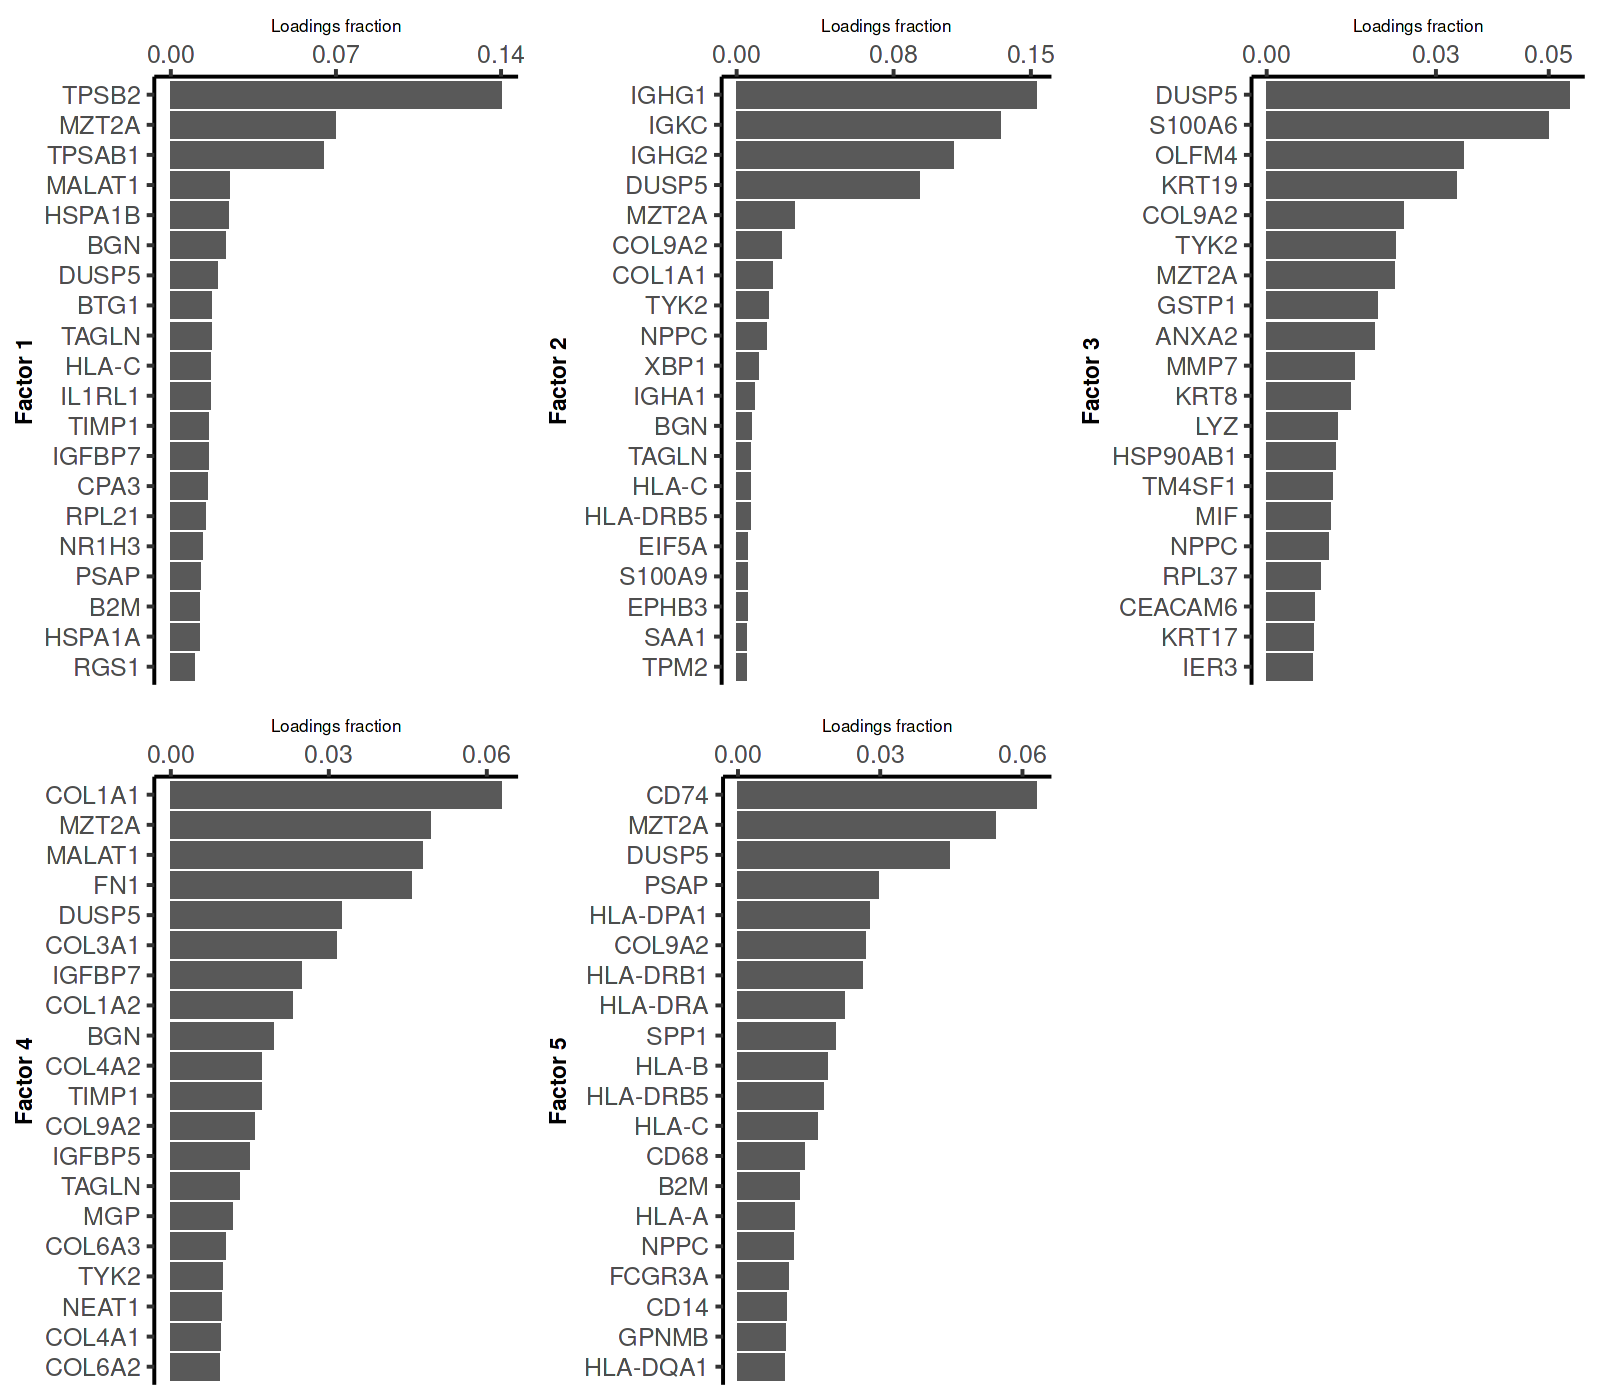

In [35]:
# Plot some loadings for the factors
options(repr.plot.width = 8, repr.plot.height = 7, repr.plot.res = 200)

my_plots <- lapply(
  c(1:k),
  function(i) {

    Hi = H %>% filter(factor == i)

    gene_order = Hi %>% arrange(-frac) %>% pull(gene) %>% head(20) %>% rev

    p_bar = Hi %>%
      filter(gene %in% gene_order) %>%
      mutate(gene = factor(gene, gene_order)) %>%
      ggplot(
        aes(x = frac, y = gene)
      ) +
      xlab('Loadings fraction') +
      ylab(paste0('Factor ',as.character(i))) +
      geom_col() +
      theme_classic(base_line_size = .5) +
      scale_x_continuous(breaks=round(seq(0, max(Hi$frac), max(Hi$frac)/2),digits = 2),position = "top") +
      theme(
        axis.title.x = element_text(size=6),
        axis.title.y = element_text(size=8,face="bold")
      )
      
    return(p_bar)
  }
) 

fig <- plot_grid(plotlist = my_plots,nrow=2,align = 'h')
fig

Here, factor 3 appears to represent admixture from malignant cells since several of the top loading genes are KRT19, KRT8, and KRT17, which are specific malignant markers. Similarly, factor 5 appears to represent admixture from macrophages given the high loadings of HLA genes.

Next, we will run CRF to assign each molecule to one of these factors. Then, we can remove the molecules coming from contaminating cell types.

In [43]:
run_crf_ct <- function(df_ct,H) {
    #### running crf for all cells of the cell type
    crf_res = df_ct %>%
      split(.$cell, drop = T) %>%
      mclapply(
        function(df_c) {
          run_crf(df_c, H, k = k,h=5)
        },mc.preschedule=TRUE,mc.cores=15
      ) %>%
      bind_rows()

    rownames(df_ct) <- df_ct$mol_id
    crf_res <- cbind.data.frame(df_ct[crf_res$id,],crf_res)
    crf_res <- crf_res[,1:(ncol(crf_res)-1)]
    return(crf_res)
}

In [44]:
# run crf
df_fib_crf <- run_crf_ct(df,H)

# this appended a column 'factor' indicating which factor each molecule has been assigned to
head(df_fib_crf)


,cell,gene,mol_id,x,y,z,id,factor
,<chr>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<chr>,<int>
11471268,c_1_10_1168,NPPC,11471268,5252.341,28911.26,3.2,11471268,5
11471269,c_1_10_1168,TAGLN,11471269,5257.622,28911.85,3.2,11471269,4
11471270,c_1_10_1168,TNFRSF18,11471270,5256.205,28914.79,3.2,11471270,4
11471271,c_1_10_1168,COL3A1,11471271,5257.909,28912.74,3.2,11471271,4
11471272,c_1_10_1168,NPPC,11471272,5258.719,28904.84,3.2,11471272,4
11471273,c_1_10_1168,MZT2A,11471273,5254.037,28911.86,3.2,11471273,5


In [45]:
# now, remove the molecules assigned to the admixture factors
mol_id_keep <- rownames(df_fib_crf)[df_fib_crf$factor %in% c(1,2,4)]
df_fib_cln <- df_fib_crf[mol_id_keep,]

print(paste0('Number of molecules originally: ',nrow(df_fib_crf)))
print(paste0('Number of molecules after cleaning: ',nrow(df_fib_cln)))

[1] "Number of molecules originally: 251991"
[1] "Number of molecules after cleaning: 218611"


Lastly, we'll show the expression of some native fibroblast markers as well as contaminating malignant markers pre vs. post cleaning

In [46]:
# compute counts matrix from molecule level data
dat_orig <- df_fib_crf %>% count(gene, cell) %>%
      reshape2::dcast(cell ~ gene, value.var = 'n', fill = 0) %>%
      as.data.frame() %>%
      tibble::column_to_rownames('cell')
dat_orig <- t(dat_orig)

dat_cln <- df_fib_cln %>% count(gene, cell) %>%
      reshape2::dcast(cell ~ gene, value.var = 'n', fill = 0) %>%
      as.data.frame() %>%
      tibble::column_to_rownames('cell')
dat_cln <- t(dat_cln)

In [51]:
# normalize counts
dat_orig_norm <- sweep(dat_orig,2,colSums(dat_orig),'/')
dat_cln_norm <- sweep(dat_cln,2,colSums(dat_cln),'/')

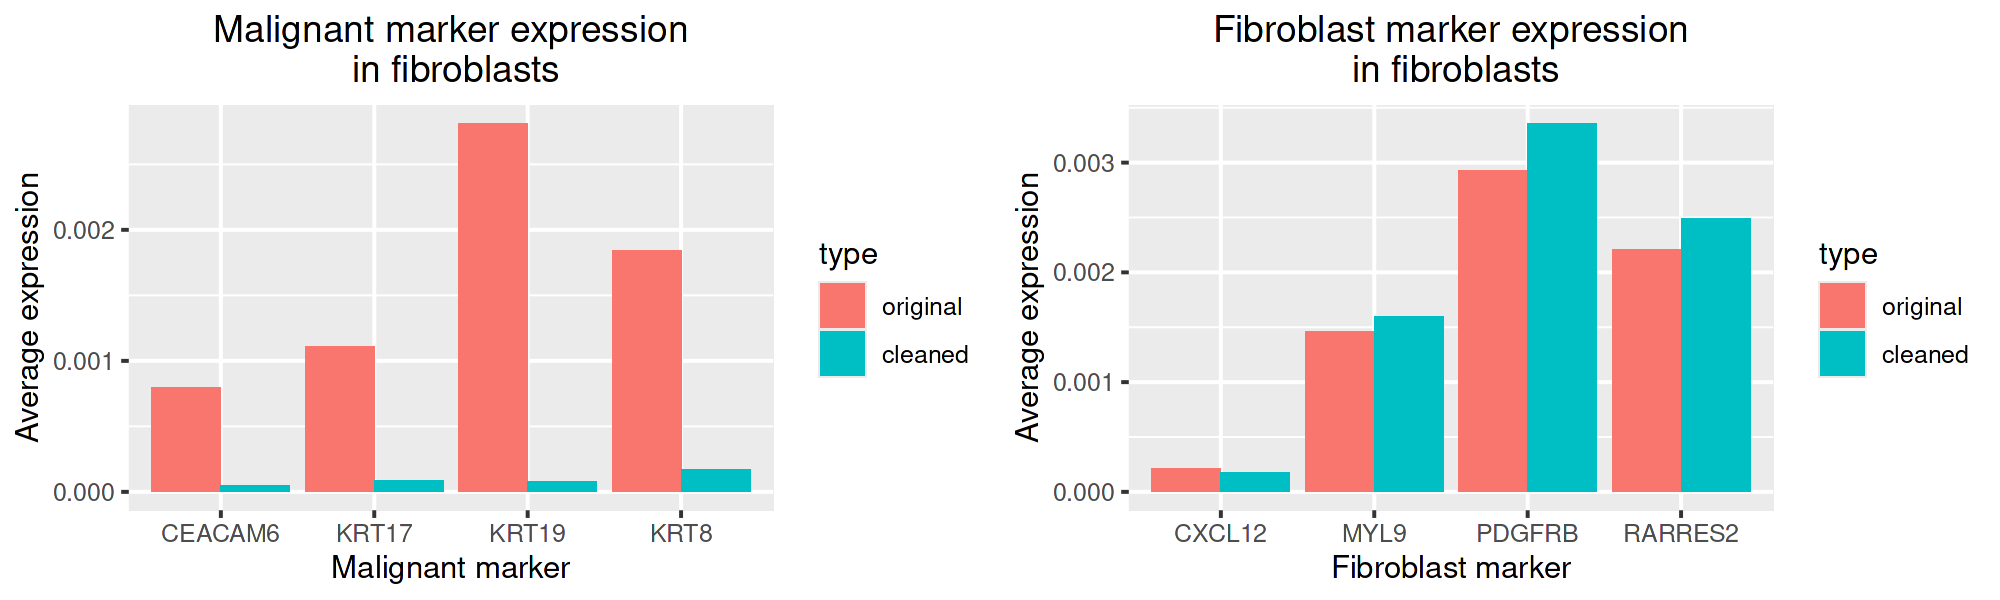

In [77]:
options(repr.plot.width = 10, repr.plot.height = 3, repr.plot.res = 200)

malignant_marks <- c('KRT19','KRT8','KRT17','CEACAM6')
fibroblast_marks <- c('MYL9','CXCL12','PDGFRB','RARRES2')

mal_av_expr_before <- rowMeans(dat_orig_norm[malignant_marks,])
fib_av_expr_before <- rowMeans(dat_orig_norm[fibroblast_marks,])

mal_av_expr_after <- rowMeans(dat_cln_norm[malignant_marks,])
fib_av_expr_after <- rowMeans(dat_cln_norm[fibroblast_marks,])

tmp1a <- cbind.data.frame(malignant_marks,mal_av_expr_before,'original')
colnames(tmp1a) <- c('gene','av_expr','type')
tmp1b <- cbind.data.frame(malignant_marks,mal_av_expr_after,'cleaned')
colnames(tmp1b) <- c('gene','av_expr','type')
tmp1 <- rbind.data.frame(tmp1a,tmp1b)
tmp1$type <- factor(tmp1$type,levels=c('original','cleaned'))

p1 <- ggplot(tmp1,aes(x=gene,y=av_expr,fill=type)) +
    geom_bar(stat="identity", position=position_dodge()) +
    xlab('Malignant marker') +
    ylab('Average expression') +
    ggtitle('Malignant marker expression\n in fibroblasts') +
    theme(plot.title = element_text(hjust = 0.5))

tmp1a <- cbind.data.frame(fibroblast_marks,fib_av_expr_before,'original')
colnames(tmp1a) <- c('gene','av_expr','type')
tmp1b <- cbind.data.frame(fibroblast_marks,fib_av_expr_after,'cleaned')
colnames(tmp1b) <- c('gene','av_expr','type')
tmp1 <- rbind.data.frame(tmp1a,tmp1b)
tmp1$type <- factor(tmp1$type,levels=c('original','cleaned'))

p2 <- ggplot(tmp1,aes(x=gene,y=av_expr,fill=type)) +
    geom_bar(stat="identity", position=position_dodge()) +
    xlab('Fibroblast marker') +
    ylab('Average expression') +
    ggtitle('Fibroblast marker expression\n in fibroblasts') +
    theme(plot.title = element_text(hjust = 0.5))

cowplot::plot_grid(p1,p2,nrow=1)